In [12]:
import cv2

img = cv2.imread(r'he/img/Utopia_gt.png')
cv2.imwrite('Utopia_gt1.png', img[195:595, :400, :])

True

In [6]:
import scipy.io as sio
import numpy as np
import cv2

def normalize(img):
    img = img.astype(np.float32)
    img_min = np.min(img)
    img_max = np.max(img)
    denominator = img_max - img_min

    if denominator < 1e-10:
        return np.zeros_like(img)

    return (img - img_min) / denominator


data_path = r'./he\260221火星加噪数据\holden_N.mat'
data_mat = sio.loadmat(data_path)

data_key = [k for k in data_mat.keys() if not k.startswith('_')][0]
data = data_mat[data_key].astype(np.float32)
data.shape

(400, 400, 3)

In [2]:
import cv2
import numpy as np
from skimage.filters import gabor
from skimage.feature import local_binary_pattern
from skimage.filters.rank import entropy
from skimage.morphology import disk



def feature_map(img, method, name):
    if method.lower() == 'sobel':
        # Sobel 算子提取梯度幅度
        grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        img1 = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    elif method.lower() =='lbp':
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        # LBP 结果通常是分类索引，需归一化以便可视化
        img1 = cv2.normalize(lbp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    elif method.lower() =='entropy':
        ent_img = entropy(img, disk(5))
        img1 = cv2.normalize(ent_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    
    cv2.imwrite(f'{name}_feature_{method.lower()}.png', img1)
    

In [4]:
img = cv2.imread(r'./he/raw/holden_PCA.jpg', cv2.IMREAD_GRAYSCALE)
feature_map(img, method='sobel', name='holden_PCA')
feature_map(img, method='lbp', name='holden_PCA')
feature_map(img, method='entropy', name='holden_PCA')

### fuse

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fuse_feature_maps(map1, map2, alpha=0.5):
    """
    map1: 特征图1 (如 LBP，代表局部细节)
    map2: 特征图2 (如 Grad-CAM 或 CNN 特征，代表全局语义)
    alpha: 融合权重
    """
    # 1. 确保尺寸一致
    if map1.shape != map2.shape:
        map2 = cv2.resize(map2, (map1.shape[1], map1.shape[0]))

    # 2. 归一化到 0-255
    m1 = cv2.normalize(map1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    m2 = cv2.normalize(map2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # 3. 视觉效果最强的融合：加权叠加
    # 这样可以在保留 CNN 激活区域的同时，看到 LBP 的地表纹理
    fused = cv2.addWeighted(m1, alpha, m2, 1-alpha, 0)
    
    # 4. 进阶视觉增强：乘法融合 (Highlight 效果)
    # 这种方法会让两个特征图共同覆盖的区域变得异常明亮
    fused_mul = (m1.astype(float) * m2.astype(float) / 255.0).astype(np.uint8)
    
    return fused, fused_mul


# 示例调用
feat1 = cv2.imread(r'./he/img/Utopia_pan_fm.png')
feat2 = cv2.imread(r'./he/img/Utopia_C_fm.png')
res_weighted, res_multiplied = fuse_feature_maps(feat1, feat2, alpha=0.8)

# 保存
cv2.imwrite('Utopia_fused_fm_w.png', res_weighted)
cv2.imwrite('Utopia_fused_fm_m.png', res_multiplied)

True

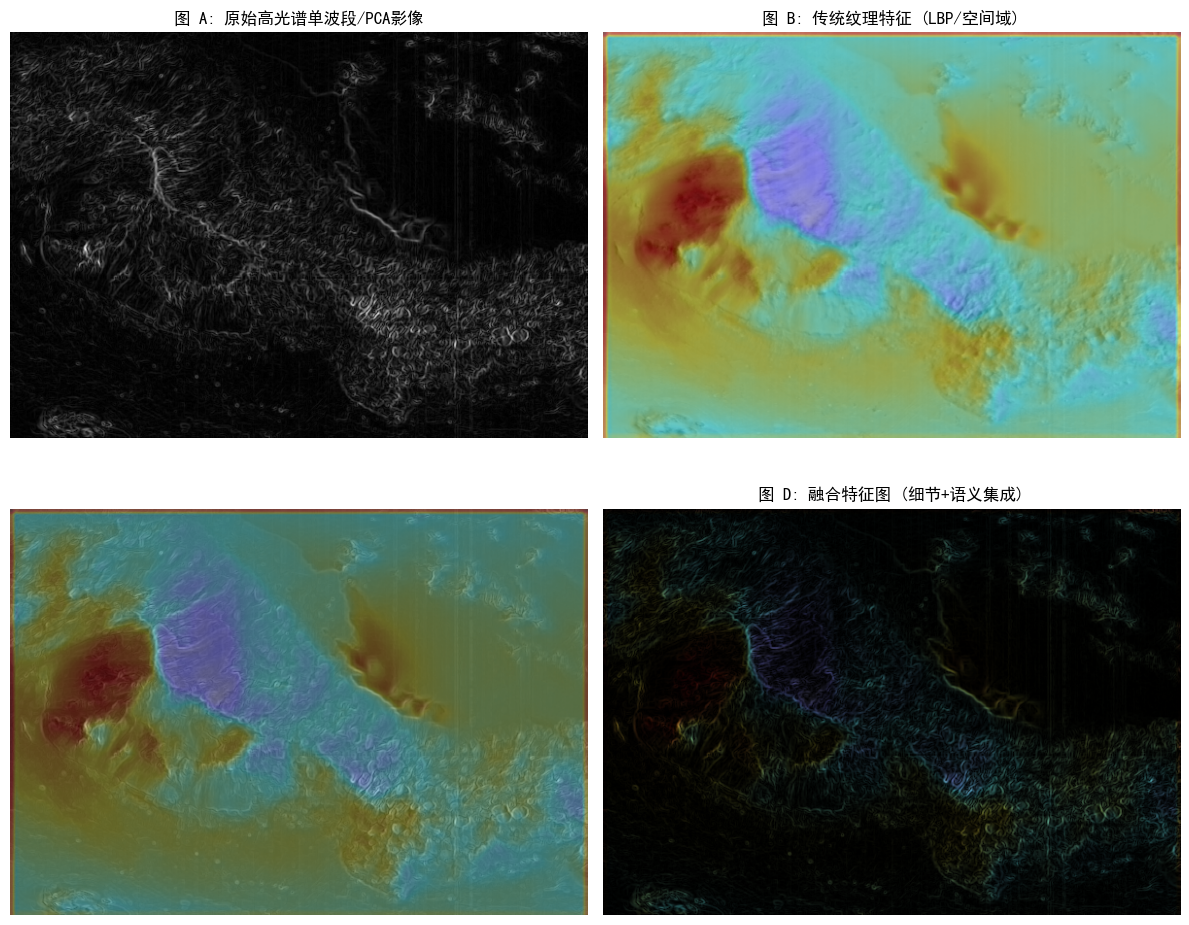

In [9]:
def plot_comparison(img1, img2, img3, img4):
    # 设置中文字体（如果是中文报告，防止乱码，Windows环境通常用黑体SimHei）
    plt.rcParams['font.sans-serif'] = ['SimHei'] 
    plt.rcParams['axes.unicode_minus'] = False

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 第一张：原始影像
    axes[0, 0].imshow(img1, cmap='gray')
    axes[0, 0].set_title("图 A: 原始高光谱单波段/PCA影像", fontsize=12)
    axes[0, 0].axis('off')

    # 第二张：传统特征 (LBP/Gabor)
    axes[0, 1].imshow(img2, cmap='jet') # 使用 jet 颜色映射增加视觉对比
    axes[0, 1].set_title("图 B: 传统纹理特征 (LBP/空间域)", fontsize=12)
    axes[0, 1].axis('off')

    # 第三张：深度学习特征 (CNN/Grad-CAM)
    axes[1, 0].imshow(img3, cmap='magma')
    axes[1, 1].set_title("图 C: CNN深层抽象特征 (语义域)", fontsize=12)
    axes[1, 0].axis('off')

    # 第四张：融合后的特征图
    # 如果融合图是彩色的，去掉 cmap='viridis'
    axes[1, 1].imshow(img4, cmap='viridis') 
    axes[1, 1].set_title("图 D: 融合特征图 (细节+语义集成)", fontsize=12)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.savefig('feature_comparison_report.png', dpi=300) # 高清保存用于报告
    plt.show()

# 调用函数
# 注意：确保所有输入的 size 是一致的，如果不一致请用 cv2.resize 处理
plot_comparison(feat1, feat2, res_weighted, res_multiplied)